In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import seaborn as sns

In [2]:
energy = pd.read_csv('elusage.csv', index_col = False)

In [3]:
energy.head(10)

,average_temperature,month,average_electricity_usage
0,73,8,24.828
1,67,9,24.688
2,57,10,19.310
3,43,11,59.706
4,26,12,99.667
5,41,1,49.333
6,38,2,59.375
7,46,3,55.172
8,54,4,55.517
9,60,5,25.938


## Getting informations about DataFrame (inproper or missing values and types of data)

In [4]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   average_temperature        55 non-null     int64  
 1   month                      55 non-null     int64  
 2   average_electricity_usage  55 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


#### There are no missing values and all of them are numeric type.

---

## Global plot settings as a function

In [34]:
def global_plot_sets():
    plt.rc('xtick', color = 'k', labelsize = 16, direction = 'out')
    plt.rc('ytick', color = 'k', labelsize = 16, direction = 'out')
    plt.rc('axes', labelsize = 20, labelpad = 18, titlesize = 24, facecolor = '#bfbfbf', axisbelow = 'True')
    plt.rc('grid', color = 'w', linestyle = '-.', linewidth = 0.6)
    plt.rc('legend', facecolor = 'w', fontsize = 16)
    plt.rc('xtick.major', size = 5, width = 1)
    plt.rc('xtick.minor', size = 2.5, width = 0.75)
    plt.rc('ytick.major', size = 5, width = 1)
    plt.rc('ytick.minor', size = 2.5, width = 0.75)

## Plots displaying dependancy between measured data

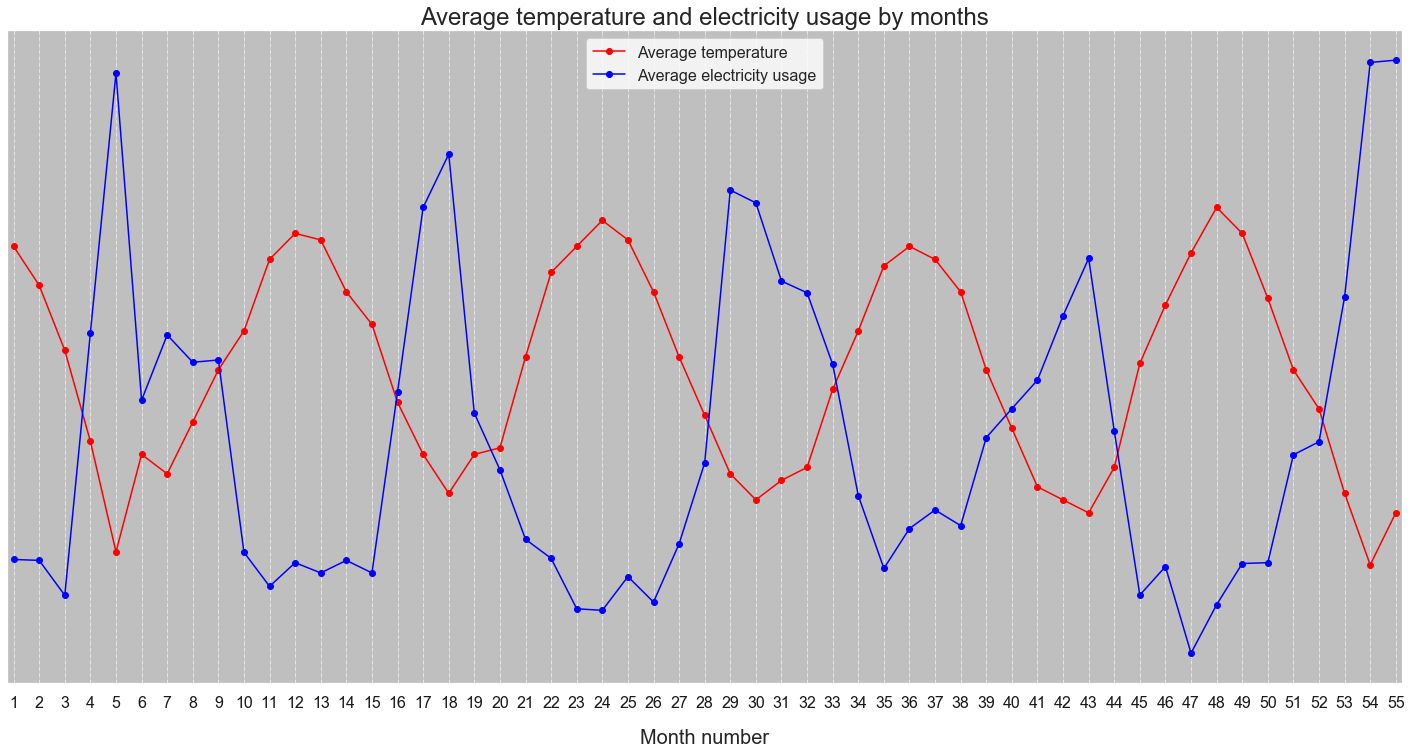

In [35]:
plt.figure(figsize=(25, 12))

# Range of measured data (55 months)
x_range = np.arange(1, len(energy) + 1)

global_plot_sets()
plt.plot(x_range, energy['average_temperature'], c = 'red', marker = 'o', label = 'Average temperature')
plt.plot(x_range, energy['average_electricity_usage'], c = 'blue', marker = 'o', label = 'Average electricity usage')
plt.xlabel('Month number')
plt.xlim(x_range.min() - 0.25, x_range.max() + 0.25)
plt.xticks(x_range)
plt.yticks([])
plt.title('Average temperature and electricity usage by months')
plt.legend(loc='upper center')

plt.show()

---

# **Statistics for data set**

## Compare basic stats for `'average_temperature'` and `'average_electricity_usage'`

In [7]:
col_name = ['average_temperature', 'average_electricity_usage']
energy[col_name].describe().round(1)

,average_temperature,average_electricity_usage
count,55.0,55.0
mean,53.8,43.3
std,15.5,24.0
min,24.0,10.4
25%,40.0,24.3
50%,54.0,38.6
75%,68.0,57.4
max,79.0,101.7


#### `'average_temperature'` dataset is close to normal distribution, but for `'average_electricity_usage'` we will make the 3 normality tests - if they failed data will be transform by *normalization*.

# Statistical Normality Tests

### 3 normality tests will be used to compare data with normal (Gaussian) characteristic. That tests will be taken in the order from the list below: 

- Shapiro-Wilk, 
- D'Agostino and Pearson's, 
- Anderson-Darling,

### till the any of them give 'fail to reject H0' result or all of the tests show 'reject H0'.

In [8]:
# Shapiro-Wilk Test
from numpy.random import seed, randn
from scipy.stats import shapiro

def ShapiroWilk_test(col_name):
    # normality test
    stat, p = shapiro(energy[col_name])
    print("For '{0:s}' column data:".format(col_name))
    print('Statistics = {0:.3f}, p = {1:.3f}'.format(stat, p))
    
    # result interpretation
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0) \n')
    else:
        print('Sample does not look Gaussian (reject H0) \n')
    

ShapiroWilk_test_result = list(map(lambda x: ShapiroWilk_test(x), col_name))

For 'average_temperature' column data:
Statistics = 0.942, p = 0.010
Sample does not look Gaussian (reject H0) 

For 'average_electricity_usage' column data:
Statistics = 0.899, p = 0.000
Sample does not look Gaussian (reject H0) 



### All data did not pass the first test - we will use next test.

In [11]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest

def AgostinoPearson_test(col_name):
    # normality test
    stat, p = normaltest(energy[col_name])
    print("For '{0:s}' column data:".format(col_name))
    print('Statistics = {0:.3f}, p = {1:.3f}'.format(stat, p))

    # result interpretation
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0) \n')
    else:
        print('Sample does not look Gaussian (reject H0) \n')
    

AgostinoPearson_test_result = list(map(lambda x: AgostinoPearson_test(x), col_name))

For 'average_temperature' column data:
Statistics = 19.556, p = 0.000
Sample does not look Gaussian (reject H0) 

For 'average_electricity_usage' column data:
Statistics = 6.821, p = 0.033
Sample does not look Gaussian (reject H0) 



### All data did not pass the first test - we will try the last test (Anderson-Darling).

In [12]:
# Anderson-Darling Test
from scipy.stats import anderson

def AndersonDarling_test(col_name):
    result = anderson(energy[col_name])
    print("For '{0:s}' column data:".format(col_name))
    print('Statistic: {0:.3f}'.format(result.statistic))
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('{0:.3f}: {1:.3f}, data looks normal (fail to reject H0)'.format(sl, cv))
        else:
            print('{0:.3f}: {1:.3f}, data does not look normal (reject H0)'.format(sl, cv))
            

AndersonDarling_test_result = list(map(lambda x: AndersonDarling_test(x), col_name))

For 'average_temperature' column data:
Statistic: 1.072
15.000: 0.541, data does not look normal (reject H0)
10.000: 0.616, data does not look normal (reject H0)
5.000: 0.739, data does not look normal (reject H0)
2.500: 0.862, data does not look normal (reject H0)
1.000: 1.026, data does not look normal (reject H0)
For 'average_electricity_usage' column data:
Statistic: 1.843
15.000: 0.541, data does not look normal (reject H0)
10.000: 0.616, data does not look normal (reject H0)
5.000: 0.739, data does not look normal (reject H0)
2.500: 0.862, data does not look normal (reject H0)
1.000: 1.026, data does not look normal (reject H0)


### Graphical comparison of used data with *qqplot* visualisations

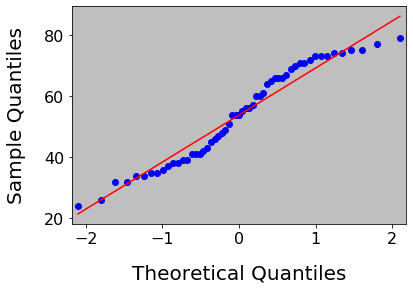

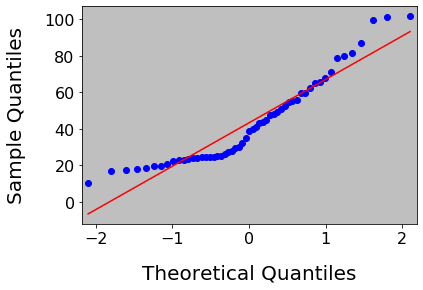

In [13]:
from statsmodels.graphics.gofplots import qqplot

# q-q plot
qqplot(energy['average_temperature'], line = 's')
qqplot(energy['average_electricity_usage'], line = 's')

plt.show()

---

## Looking for *Pearson* and *Spearman correlation*

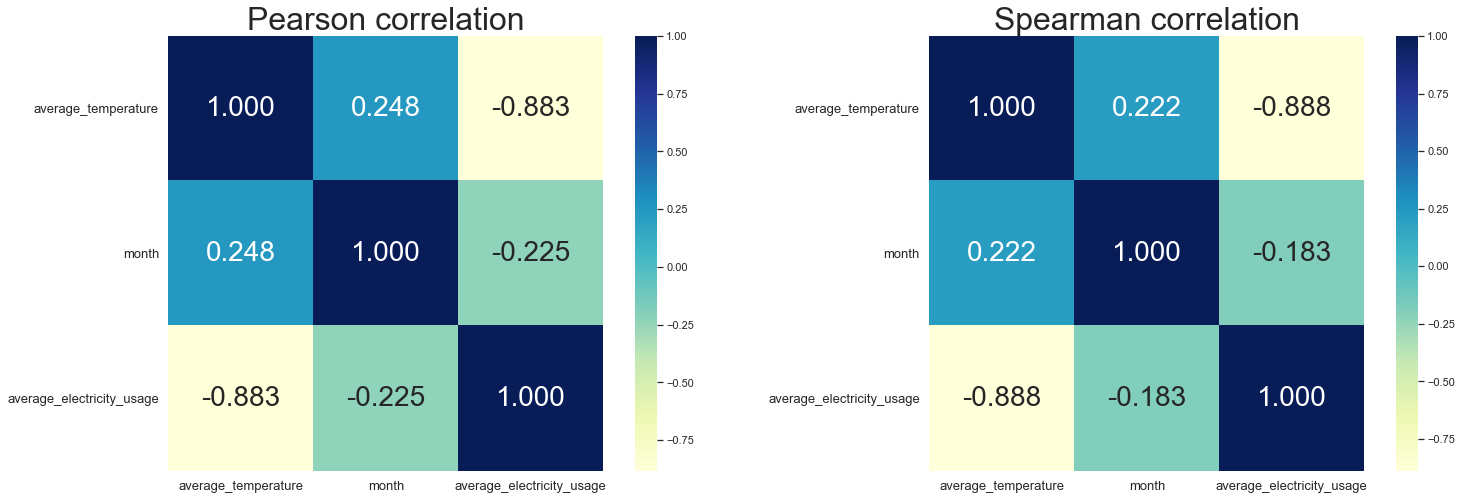

In [14]:
sns.set()

# Draw a heatmap with the numeric values in each cell
fig = plt.figure(figsize=(25, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax_ = [ax1, ax2]

correlation_data = [energy.corr(method = 'pearson'), energy.corr(method = 'spearman')]
titles_array = ['Pearson correlation', 'Spearman correlation']

# We use axs parameter to tell seaborn which subplot to use for this plot
for axs, data, titles in zip(ax_, correlation_data, titles_array):
    sns.heatmap(data = data, fmt = '.3f', square = True, cmap = "YlGnBu", annot = True, annot_kws = {"fontsize": 28}, ax = axs)
    axs.set_xticklabels(ax1.get_xticklabels(), fontsize = 13)
    axs.set_yticklabels(ax1.get_xticklabels(), rotation = 0, ha = "right", rotation_mode = "anchor", fontsize = 13)
    axs.set_title(titles, fontsize = 32)
    
plt.show()

### Very high Pearson correlation between temperature and electricity usage give us a clue to limit our regression searching task to linear methods only, but we will use another regression method to see the difference in results.
### Polynomial functions using to compare will have degrees from 1 to 5 - higher degree values could be a reason of overfitting the final model.

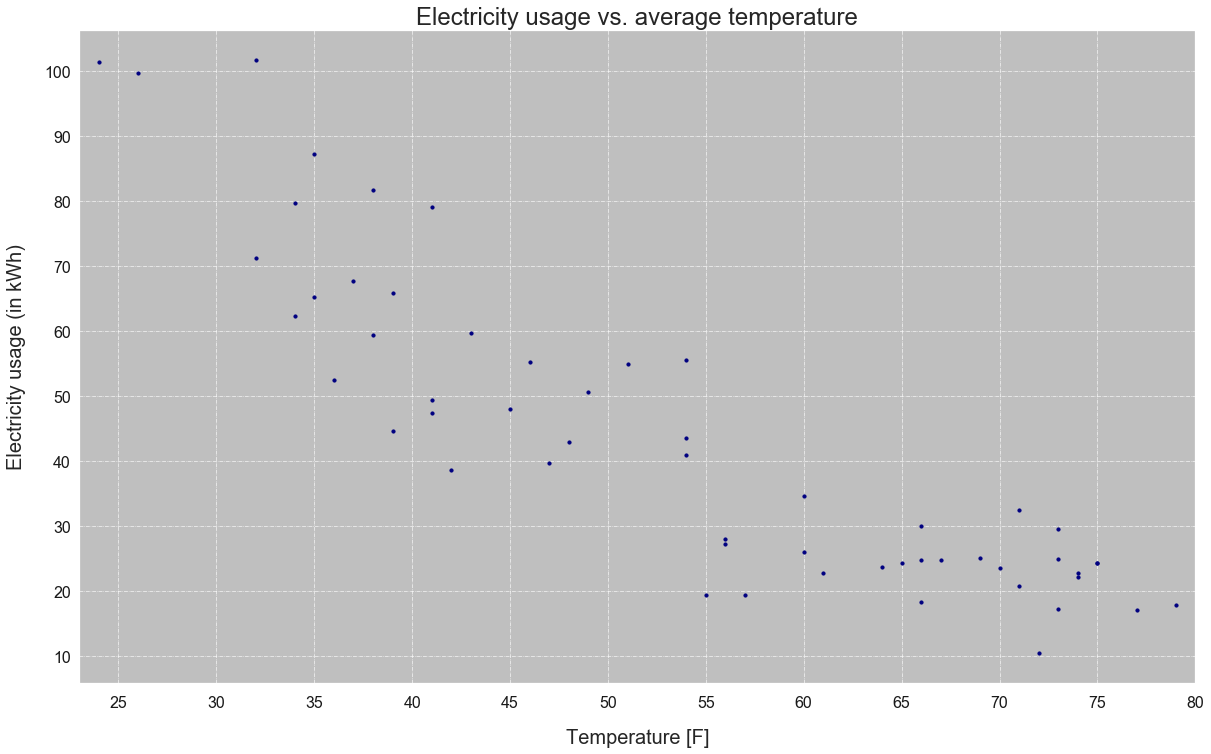

In [36]:
fig, ax = plt.subplots(figsize=(20, 12))
global_plot_sets()

plt.scatter(energy['average_temperature'], energy['average_electricity_usage'], c = 'navy', marker = 'o', s = 10)
plt.xlabel('Temperature [F]')
plt.ylabel('Electricity usage (in kWh)')
plt.xlim(energy['average_temperature'].min() - 1, energy['average_temperature'].max() + 1)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.title('Electricity usage vs. average temperature')

plt.show()

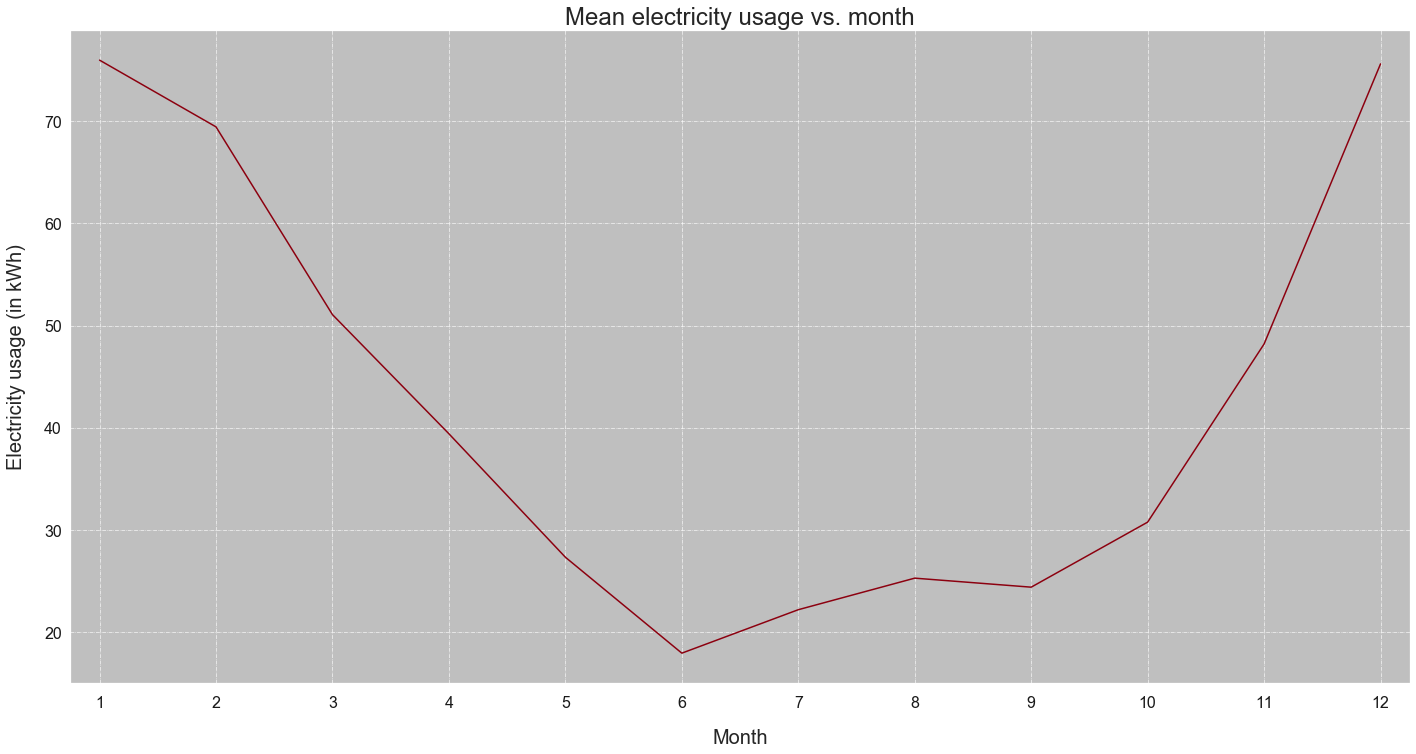

In [37]:
fig, ax = plt.subplots(figsize=(24, 12))

# Mean values will be used because of not equal number of every months in data set
month_list = energy.groupby('month')['average_electricity_usage'].mean()
month_list_number = month_list.keys()

plt.plot(month_list_number, month_list, aa='yes', color = '#8c000f')
plt.xlabel('Month')
plt.ylabel('Electricity usage (in kWh)')
plt.xlim(energy['month'].min() - 0.25, energy['month'].max() + 0.25)
plt.xticks(range(energy['month'].min(), energy['month'].max() + 1))
plt.title('Mean electricity usage vs. month')

plt.show()